In [1]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (abundance, dominance, diversity, stand height)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys, time
import pandas as pd
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgba

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

albers = 'EPSG:5070' # albers CONUS
utm = 'EPSG:32613' # UTM Zone 13N

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
print(f"\nThere are [{len(grid)}] grids across [{len(grid['Fire_ID'].unique())}] fires.\n")

# create a unique ID
grid['grid_idx'] = grid['Fire_ID'].astype(str) + grid['grid_index'].astype(str)

# add the centroid lat/lon to the grid data
df = grid.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y
grid = grid.merge(df[['grid_idx','x','y']], on='grid_idx', how='left')
del df
print(f"\n{grid.columns}\n")

# Drop any dupicate grids ...
print(f"Dropping [{grid.duplicated(subset=['grid_idx']).sum()}] duplicate grids.\n")
grid = grid.drop_duplicates(subset=['grid_idx'], keep='first')


There are [57232] grids across [100] fires.


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'grid_idx', 'x', 'y'],
      dtype='object')

Dropping [0] duplicate grids.



Fractional overlap:
count    57232.000000
mean         2.023404
std          2.001402
min          0.000003
25%          0.587511
50%          1.493563
75%          2.771206
max         24.470760
Name: overlap, dtype: float64



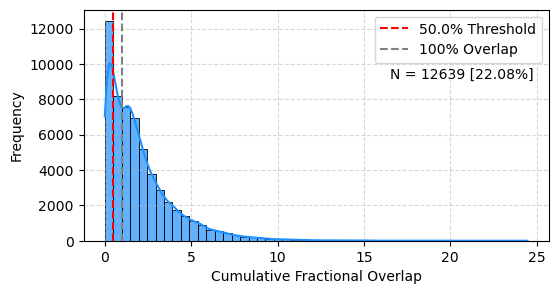

Plot saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/grid_overlap_distribution.png


In [3]:
# Check out the distribution of grid overlap with FRP observations
thresh = 0.50
print(f"Fractional overlap:\n{grid['overlap'].describe()}\n")
n_small = grid[grid['overlap'] < thresh]['grid_idx'].count() # less than 5% spatial overlap

# Plot the distribution of the fractional overlap
plt.figure(figsize=(6,3))
sns.histplot(grid['overlap'], kde=True, bins=50, color='dodgerblue', alpha=0.7)

# Add vertical line for the threshold and for 100%
plt.axvline(x=thresh, color='red', linestyle='--', label=f'{thresh*100}% Threshold')
plt.axvline(x=1, color='grey', linestyle='--', label='100% Overlap')

# Customize the plot
# plt.title('Distribution of Grid Overlap Fraction')
plt.xlabel('Cumulative Fractional Overlap')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.text(16.5, plt.ylim()[1] * 0.7, 
         f'N = {n_small} [{round(n_small/len(grid)*100,2)}%]', 
         fontsize=10, color='black')

# Save the plot
out_path = os.path.join(projdir, 'figures/grid_overlap_distribution.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"Plot saved to: {out_path}")

In [4]:
# filter out grids below the overlap threshold
print(f"Dropping [{n_small} ({round(n_small/len(grid)*100,2)}%)] grids with <{thresh*100}% fractional overlap.")
grid = grid[grid['overlap'] >= thresh] # remove these observations
print(len(grid))

Dropping [12639 (22.08%)] grids with <50.0% fractional overlap.
44593


In [5]:
# Load the FORTYPCD and the Tree Table summaries

# FORTYPCD
fp = os.path.join(projdir,'data/tabular/mod/gridstats_fortypnm_gp_fc.csv')
fortyp = pd.read_csv(fp)
print(f"FORTYPCD columns:\n{fortyp.columns}\n")

# Tree Table
fp = os.path.join(projdir,'data/tabular/mod/gridstats_treetable.csv')
trees = pd.read_csv(fp)
trees.drop(columns=['Unnamed: 0','forest_pct'], inplace=True)
print(f"Tree Table columns:\n{trees.columns}\n")

# Check on how many grids match
print(f"\tFORTYP unique grids: {len(fortyp['grid_idx'].unique())}")
print(f"\t\t total rows: {len(fortyp)}")
print(f"\tTree Table unique grids: {len(trees['grid_idx'].unique())}")
print(f"\t\t total rows: {len(trees)}")

FORTYPCD columns:
Index(['Unnamed: 0', 'grid_idx', 'fortypnm_gp', 'fortyp_pixels',
       'total_pixels', 'fortyp_pct', 'forest_pixels', 'forest_pct',
       'canopypct_mean', 'balive_sum', 'lf_forest_cc_mean',
       'lf_forest_ch_mean'],
      dtype='object')

Tree Table columns:
Index(['grid_idx', 'species_gp_n', 'tmid_n', 'ba_live', 'ba_dead', 'ba_ld',
       'tpp_live', 'tpp_dead', 'tpp_ld', 'qmd_live', 'qmd_dead', 'qmd_ld',
       'tree_ht_live', 'tree_ht_dead', 'tree_dia_live', 'tree_dia_dead',
       'H_ba', 'H_tpp', 'ba_live_total', 'ba_dead_total', 'tpp_live_total',
       'tpp_dead_total', 'qmd_live_mean', 'qmd_dead_mean', 'tree_ht_live_mean',
       'tree_ht_dead_mean', 'tree_dia_live_mean', 'tree_dia_dead_mean',
       'ba_live_pr', 'tpp_live_pr'],
      dtype='object')

	FORTYP unique grids: 44312
		 total rows: 159165
	Tree Table unique grids: 44439
		 total rows: 219679


In [6]:
# check how many matching grids
match = fortyp[fortyp['grid_idx'].isin(trees['grid_idx'].unique())]
# Check on how many grids match
print(f"\n\tFORTYP unique grids: {len(match['grid_idx'].unique())}")
print(f"\t\t total rows: {len(match)}")
print(f"\tTree Table unique grids: {len(trees['grid_idx'].unique())}")
print(f"\t\t total rows: {len(trees)}")
del match
gc.collect()


	FORTYP unique grids: 44306
		 total rows: 159159
	Tree Table unique grids: 44439
		 total rows: 219679


91

In [7]:
# calculate the dominant forest type using the FORTYPCD
dfortyp = fortyp.loc[fortyp.groupby('grid_idx')['fortyp_pct'].idxmax()]
dfortyp = dfortyp[[
    'grid_idx','fortypnm_gp','fortyp_pct',
    'forest_pct','canopypct_mean','balive_sum',
    'lf_forest_cc_mean', 'lf_forest_ch_mean'
]]
dfortyp = dfortyp[dfortyp['grid_idx'].isin(trees['grid_idx'].unique())] # retain matching grids
dfortyp.columns

Index(['grid_idx', 'fortypnm_gp', 'fortyp_pct', 'forest_pct', 'canopypct_mean',
       'balive_sum', 'lf_forest_cc_mean', 'lf_forest_ch_mean'],
      dtype='object')

In [8]:
dfortyp['fortypnm_gp'].unique()

array(['Quaking aspen', 'Spruce-fir', 'Douglas-fir', 'Ponderosa pine',
       'Gambel oak', 'Lodgepole pine', 'White fir', 'Piñon-juniper'],
      dtype=object)

In [9]:
# Check on how many matches there are between the dominant type and the Tree Table
matches = (dfortyp['grid_idx'].isin(trees[trees['species_gp_n'].isin(dfortyp['fortypnm_gp'])]['grid_idx'])).sum()
# Print the results
total_grids = dfortyp['grid_idx'].nunique()
print(f"\nTotal grids: {total_grids}\n")
print(f"{matches} ({(matches / total_grids) * 100:.2f}%)\n")
del matches, total_grids
gc.collect()


Total grids: 44306

44306 (100.00%)



6906

In [10]:
# merge to the tree table metrics
tree_metrics = dfortyp.merge(trees, on='grid_idx', how='left')
tree_metrics.head()

,grid_idx,fortypnm_gp,fortyp_pct,forest_pct,canopypct_mean,balive_sum,lf_forest_cc_mean,lf_forest_ch_mean,species_gp_n,tmid_n,...,tpp_live_total,tpp_dead_total,qmd_live_mean,qmd_dead_mean,tree_ht_live_mean,tree_ht_dead_mean,tree_dia_live_mean,tree_dia_dead_mean,ba_live_pr,tpp_live_pr
0,819725,Quaking aspen,0.302198,40.10989,41.287671,5058.04834,15.741758,62.362637,Douglas-fir,8,...,2127.67757,270.575649,88.343982,59.839315,33.567869,22.728869,8.124283,8.124283,0.077776,0.036088
1,819725,Quaking aspen,0.302198,40.10989,41.287671,5058.04834,15.741758,62.362637,Gambel oak,4,...,2127.67757,270.575649,88.343982,59.839315,33.567869,22.728869,8.124283,8.124283,0.033535,0.183367
2,819725,Quaking aspen,0.302198,40.10989,41.287671,5058.04834,15.741758,62.362637,Lodgepole pine,2,...,2127.67757,270.575649,88.343982,59.839315,33.567869,22.728869,8.124283,8.124283,0.033663,0.034830
3,819725,Quaking aspen,0.302198,40.10989,41.287671,5058.04834,15.741758,62.362637,Piñon-juniper,2,...,2127.67757,270.575649,88.343982,59.839315,33.567869,22.728869,8.124283,8.124283,0.104165,0.059308
4,819725,Quaking aspen,0.302198,40.10989,41.287671,5058.04834,15.741758,62.362637,Quaking aspen,18,...,2127.67757,270.575649,88.343982,59.839315,33.567869,22.728869,8.124283,8.124283,0.497716,0.452034


In [11]:
print(len(tree_metrics))

219408


In [12]:
tree_metrics.columns

Index(['grid_idx', 'fortypnm_gp', 'fortyp_pct', 'forest_pct', 'canopypct_mean',
       'balive_sum', 'lf_forest_cc_mean', 'lf_forest_ch_mean', 'species_gp_n',
       'tmid_n', 'ba_live', 'ba_dead', 'ba_ld', 'tpp_live', 'tpp_dead',
       'tpp_ld', 'qmd_live', 'qmd_dead', 'qmd_ld', 'tree_ht_live',
       'tree_ht_dead', 'tree_dia_live', 'tree_dia_dead', 'H_ba', 'H_tpp',
       'ba_live_total', 'ba_dead_total', 'tpp_live_total', 'tpp_dead_total',
       'qmd_live_mean', 'qmd_dead_mean', 'tree_ht_live_mean',
       'tree_ht_dead_mean', 'tree_dia_live_mean', 'tree_dia_dead_mean',
       'ba_live_pr', 'tpp_live_pr'],
      dtype='object')

In [13]:
# Load the climate and topography information

# topography
fp = os.path.join(projdir,'data/earth-engine/exports/gridstats_topo.csv')
topo = pd.read_csv(fp)
# create a unique ID
topo['grid_idx'] = topo['Fire_ID'].astype(str) + topo['grid_index'].astype(str)
print(f"\n{topo.columns}\n")

# climate (gridmet)
fp = os.path.join(projdir,'data/earth-engine/exports/gridstats_gridmet_full.csv')
climate = pd.read_csv(fp)
print(f"\n{climate.columns}\n")


Index(['system:index', 'Fire_ID', 'aspect', 'chili', 'elev', 'grid_index',
       'slope', 'tpi', '.geo', 'grid_idx'],
      dtype='object')


Index(['system:index', 'Fire_ID', 'erc', 'erc_dv', 'first_obs', 'fm1000',
       'fm1000_dv', 'rmin', 'rmin_dv', 'tmmx', 'tmmx_dv', 'vpd', 'vpd_dv',
       'vs', 'vs_dv', '.geo'],
      dtype='object')



In [14]:
# tidy and merge the climate/topo
climate.rename(columns={'first_obs': 'first_obs_date'}, inplace=True) # for joining to the grid data
climate = climate[[
    'Fire_ID', 'first_obs_date', 'erc', 'erc_dv', 
    'fm1000', 'fm1000_dv', 'rmin', 'rmin_dv', 'tmmx', 'tmmx_dv', 
    'vpd', 'vpd_dv', 'vs', 'vs_dv'
]] # keep needed columns
climate['Fire_ID'] = climate['Fire_ID'].astype(str) # to match the grid column
grid['first_obs_date'] = grid['first_obs_date'].astype(str) # to match gee output
# merge climate to the grid by fire id and first acquisition day
grid_clim = grid.merge(climate, on=['Fire_ID','first_obs_date'], how='left')
print(f"\n{grid_clim.columns}\n")


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'grid_idx', 'x', 'y', 'erc', 'erc_dv', 'fm1000', 'fm1000_dv', 'rmin',
       'rmin_dv', 'tmmx', 'tmmx_dv', 'vpd', 'vpd_dv', 'vs', 'vs_dv'],
      dtype='object')



In [15]:
# merge the topography to the grid
topo = topo[['grid_idx', 'elev', 'slope', 'aspect', 'chili', 'tpi']]
grid_clim_topo = grid_clim.merge(topo, on='grid_idx', how='left')
grid_clim_topo.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'grid_idx', 'x', 'y', 'erc', 'erc_dv', 'fm1000', 'fm1000_dv', 'rmin',
       'rmin_dv', 'tmmx', 'tmmx_dv', 'vpd', 'vpd_dv', 'vs', 'vs_dv', 'elev',
       'slope', 'aspect', 'chili', 'tpi'],
      dtype='object')

In [16]:
# merge the FRP, climate, and topogrpahy to the forest metrics table
grid_clim_topo['grid_idx'] = grid_clim_topo['grid_idx'].astype(int)
grid_tm = tree_metrics.merge(grid_clim_topo, on=['grid_idx'], how='inner')
print(grid_tm.head(3))

   grid_idx    fortypnm_gp  fortyp_pct  forest_pct  canopypct_mean  \
0    819725  Quaking aspen    0.302198    40.10989       41.287671   
1    819725  Quaking aspen    0.302198    40.10989       41.287671   
2    819725  Quaking aspen    0.302198    40.10989       41.287671   

   balive_sum  lf_forest_cc_mean  lf_forest_ch_mean    species_gp_n  tmid_n  \
0  5058.04834          15.741758          62.362637     Douglas-fir       8   
1  5058.04834          15.741758          62.362637      Gambel oak       4   
2  5058.04834          15.741758          62.362637  Lodgepole pine       2   

   ...   tmmx_dv       vpd    vpd_dv        vs     vs_dv         elev  \
0  ...  3.825737  1.632481  0.434491  3.350589 -0.701609  2907.785585   
1  ...  3.825737  1.632481  0.434491  3.350589 -0.701609  2907.785585   
2  ...  3.825737  1.632481  0.434491  3.350589 -0.701609  2907.785585   

       slope      aspect       chili        tpi  
0  27.233212  143.266123  189.301124  27.759364  
1  27.233

In [17]:
len(grid_tm)

219408

In [18]:
grid_tm.columns

Index(['grid_idx', 'fortypnm_gp', 'fortyp_pct', 'forest_pct', 'canopypct_mean',
       'balive_sum', 'lf_forest_cc_mean', 'lf_forest_ch_mean', 'species_gp_n',
       'tmid_n', 'ba_live', 'ba_dead', 'ba_ld', 'tpp_live', 'tpp_dead',
       'tpp_ld', 'qmd_live', 'qmd_dead', 'qmd_ld', 'tree_ht_live',
       'tree_ht_dead', 'tree_dia_live', 'tree_dia_dead', 'H_ba', 'H_tpp',
       'ba_live_total', 'ba_dead_total', 'tpp_live_total', 'tpp_dead_total',
       'qmd_live_mean', 'qmd_dead_mean', 'tree_ht_live_mean',
       'tree_ht_dead_mean', 'tree_dia_live_mean', 'tree_dia_dead_mean',
       'ba_live_pr', 'tpp_live_pr', 'grid_index', 'grid_area', 'afd_count',
       'unique_days', 'overlap', 'frp_csum', 'frp_max', 'frp_min', 'frp_mean',
       'frp_p90', 'frp_p95', 'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp',
       'dt_max_frp', 'first_obs_date', 'last_obs_date', 't4_max', 't4_mean',
       't5_max', 't5_mean', 'day_count', 'night_count', 'frp_max_day',
       'frp_max_night', 'frp_csum_d

In [19]:
# save this file out.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_fortypnm_gp_tm_ct.csv')
grid_tm.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_fortypnm_gp_tm_ct.csv
